# Introduction to Geopandas

**Credit:**

[Vuokko Heikinheimo, Henrikki Tenkanen](https://automating-gis-processes.github.io/)  
Department of Geosciences & Geography, University of Helsinki  

**Geopandas** (http://geopandas.org/) makes it possible to work with geospatial data in Python in a relatively easy way. Geopandas combines the capabilities of the data analysis library [pandas](https://pandas.pydata.org/pandas-docs/stable/) with other packages like [shapely](https://shapely.readthedocs.io/en/stable/manual.html) and [fiona](https://fiona.readthedocs.io/en/latest/manual.html) for managing spatial data. 

The main data structures in geopandas are `GeoSeries` and `GeoDataFrame` which extend the capabilities of `Series` and `DataFrames` from pandas. This means that we can use all our pandas skills also when working with geopandas!  

The main difference between geodataframes and pandas dataframes is that a [geodataframe](http://geopandas.org/data_structures.html#geodataframe) should contain one column for geometries. By default, the name of this column is `'geometry'`. The geometry column is a [geoseries](http://geopandas.org/data_structures.html#geoseries) which contains the geometries (points, lines, polygons, multipolygons etc.) as shapely objects. 

![geodataframe.png](img/geodataframe.png)

It is conventional to import pandas as `pd`. Similarly,we will import geopandas as `gpd`:

In [1]:
import geopandas as gpd

In this lesson, we will cover basics steps needed for interacting with spatial data in Python using geopandas:

- Managing filepaths
- Reading spatial data from file 
- Geometry calculations 
- Writing spatial data to file
- Grouping and splitting spatial data into multiple layers

## Input data: Finnish topographic database 

In this lesson we will work with the [National Land Survey of Finland (NLS) topographic database (from 2018)](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/expert-users/product-descriptions/topographic-database). 
- The data set is licensed under the NLS' [open data licence](https://www.maanmittauslaitos.fi/en/opendata-licence-cc40) (CC BY 4.0).
- Structure of the data is described in a separate Excel file ([download link](http://www.maanmittauslaitos.fi/sites/maanmittauslaitos.fi/files/attachments/2018/10/maastotietokanta_kohdemalli_eng.xlsx)).
- Further information about file naming is available at [fairdata.fi](https://etsin.fairdata.fi/dataset/5023ecc7-914a-4494-9e32-d0a39d3b56ae).

For this lesson, we have acquired a subset of the topographic database as shapefiles from the Helsinki Region in Finland via the [CSC open data portal](https://avaa.tdata.fi/web/paituli/latauspalvelu):

![Paituli data download](img/Paituli_maastotietokanta_download.png)


In this lesson, we will focus on **terrain objects** (Feature group: "Terrain/1" in the topographic database). The Terrain/1 feature group contains several feature classes. **Our aim in this lesson is to save all the Terrain/1 feature classes into separate files**.

*Terrain/1 features in the Topographic Database:*

|  feature class | Name of feature                                            | Feature group |
|----------------|------------------------------------------------------------|---------------|
| 32421          | Motor traffic area                                         | Terrain/1     |
| 32200          | Cemetery                                                   | Terrain/1     |
| 34300          | Sand                                                       | Terrain/1     |
| 34100          | Rock - area                                                | Terrain/1     |
| 34700          | Rocky area                                                 | Terrain/1     |
| 32500          | Quarry                                                     | Terrain/1     |
| 32112          | Mineral resources extraction area, fine-grained material   | Terrain/1     |
| 32111          | Mineral resources extraction area, coarse-grained material | Terrain/1     |
| 32611          | Field                                                      | Terrain/1     |
| 32612          | Garden                                                     | Terrain/1     |
| 32800          | Meadow                                                     | Terrain/1     |
| 32900          | Park                                                       | Terrain/1     |
| 35300          | Paludified land                                            | Terrain/1     |
| 35412          | Bog, easy to traverse forested                             | Terrain/1     |
| 35411          | Open bog, easy to traverse treeless                        | Terrain/1     |
| 35421          | Open fen, difficult to traverse treeless                   | Terrain/1     |
| 33000          | Earth fill                                                 | Terrain/1     |
| 33100          | Sports and recreation area                                 | Terrain/1     |
| 36200          | Lake water                                                 | Terrain/1     |
| 36313          | Watercourse area                                           | Terrain/1     |


According to the [naming convention](https://etsin.fairdata.fi/dataset/5023ecc7-914a-4494-9e32-d0a39d3b56ae), all files that start with a letter `m` and end with `p` contain the objects we are interested in (Terrain/1 polygons). 

Let's store this mapping

In [ ]:
# Define mapping
terrain_types = {
    32421: "Motor traffic area",
    32200: "Cemetery",
    34300: "Sand",
    34100: "Rock area",
    34700: "Rocky area",
    32500: "Quarry",
    32112: "Mineral resources extraction area, fine-grained material",
    32111: "Mineral resources extraction area, coarse-grained material",
    32611: "Field",
    32612: "Garden",
    32800: "Meadow",
    32900: "Park",
    35300: "Paludified land",
    35412: "Bog, easy to traverse forested",
    35411: "Open bog, easy to traverse treeless",
    35421: "Open fen, difficult to traverse treeless",
    33000: "Earth fill",
    33100: "Sports and recreation area",
    36200: "Lake water",
    36313: "Watercourse area"}

## Data

The data for this tutorial is available under: `data/L4132R.shp`. Notice that Shapefile -fileformat contains many separate files such as `.dbf` that contains the attribute information, and `.prj` -file that contains information about coordinate reference system.

## Managing filepaths

Built-in module `os` provides many useful functions for interacting with the operating system. One of the most useful submodules in the os package is the [os.path-module](https://docs.python.org/2/library/os.path.html) for manipulating file paths. This week, we have data in different sub-folders and we can practice how to use `os` path tools when defining filepaths.

Let's import `os` and see how we can construct a filepath by joining a folder path and file name:

In [3]:
# Import
import os

# Define path to folder
input_folders = ['..', 'data', 'L4132R.shp', 'm_L4132R_p.shp']

# Join folder path and filename 
fp = os.path.join(*input_folders)

# Print out the full file path
print(fp)

..\data\L4132R.shp\m_L4132R_p.shp


## Reading a Shapefile

Esri Shapefile is the default file format when reading in data usign geopandas, so we only need to pass the file path in order to read in our data:

In [32]:
# Import dependencies
import geopandas as gpd

# Read file using gpd.read_file()
data = gpd.read_file(fp)

Let's check the data type:

In [33]:
type(data)

geopandas.geodataframe.GeoDataFrame

Here we see that our `data` -variable is a `GeoDataFrame`. GeoDataFrame extends the functionalities of
`pandas.DataFrame` in a way that it is possible to handle spatial data using similar approaches and datastructures as in pandas (hence the name geopandas). 

Let's check the first rows of data: 

In [34]:
data.head()

,TEKSTI,RYHMA,LUOKKA,TASTAR,KORTAR,KORARV,KULKUTAPA,KOHDEOSO,AINLAHDE,SYNTYHETKI,...,KARTOGLK,ALUEJAKOON,VERSUH,SUUNTA,SIIRT_DX,SIIRT_DY,KORKEUS,ATTR2,ATTR3,geometry
0,None,64,32421,5000,0,0.0,0,1812247077,1,20180125,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((379394.248 6689991.936, 379389.790 6..."
1,None,64,32421,5000,0,0.0,0,1718796908,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((378980.811 6689359.377, 378983.401 6..."
2,None,64,32421,20000,0,0.0,0,411167695,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((378804.766 6689256.471, 378817.107 6..."
3,None,64,32421,20000,0,0.0,0,411173768,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((379229.695 6685025.111, 379233.366 6..."
4,None,64,32421,20000,0,0.0,0,411173698,1,20180120,...,0,0,0,0,0,0,0.0,0,0,"POLYGON ((379825.199 6685096.247, 379829.651 6..."


- Check all column names:

In [35]:
for col in data.columns:
    print(col)

TEKSTI
RYHMA
LUOKKA
TASTAR
KORTAR
KORARV
KULKUTAPA
KOHDEOSO
AINLAHDE
SYNTYHETKI
KUOLHETKI
KARTOGLK
ALUEJAKOON
VERSUH
SUUNTA
SIIRT_DX
SIIRT_DY
KORKEUS
ATTR2
ATTR3
geometry


As you might guess, the column names are in Finnish. Let's keep only the relevant columns, and rename them into English:

"RYHMA" -> "GROUP"  
"LUOKKA" -> "CLASS"

In [37]:
# Keep only relevant columns
data = data[['RYHMA', 'LUOKKA', 'geometry']]

Define new column names in a dictionary:

In [38]:
# Names dict
colnames = {'RYHMA': 'GROUP',
           'LUOKKA': 'CLASS'}

Rename:

In [39]:
data = data.rename(columns=colnames)

Check the output:

In [40]:
data.head()

,GROUP,CLASS,geometry
0,64,32421,"POLYGON ((379394.248 6689991.936, 379389.790 6..."
1,64,32421,"POLYGON ((378980.811 6689359.377, 378983.401 6..."
2,64,32421,"POLYGON ((378804.766 6689256.471, 378817.107 6..."
3,64,32421,"POLYGON ((379229.695 6685025.111, 379233.366 6..."
4,64,32421,"POLYGON ((379825.199 6685096.247, 379829.651 6..."


It is always a good idea to explore your data also on a map. Creating a simple map from a `GeoDataFrame` is really easy: you can use ``.plot()`` -function from geopandas that **creates a map based on the geometries of the data**. Geopandas actually uses matplotlib for plotting.

Let's try it out, and plot our GeoDataFrame:

<AxesSubplot:>

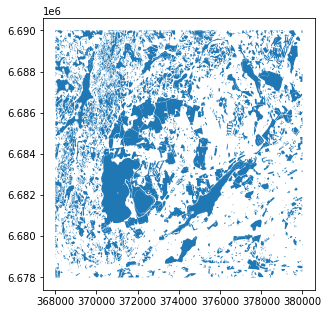

In [41]:
# Plot data
%matplotlib inline

data.plot(figsize=(5, 5))


Voilá! As we can see, it is really easy to produce a map out of your Shapefile with geopandas. Geopandas automatically positions your map in a way that it covers the whole extent of your data.

*If you know the Helsinki region, you might recognize the shapes plotted on the map!*

## Geometries in Geopandas

Geopandas takes advantage of Shapely's geometric objects. Geometries are stored in a column called *geometry* that is a default column name for
storing geometric information in geopandas.

Let's print the first 5 rows of the column 'geometry':

In [42]:
for row in data:
    print(row)

GROUP
CLASS
geometry


As we can see the `geometry` column contains familiar looking values, namely Shapely `Polygon` -objects. Since the spatial data is stored as Shapely objects, **it is possible to use Shapely methods** when dealing with geometries in geopandas.

Let's have a closer look at the polygons and try to apply some of the Shapely methods we are already familiar with.

Let's start by checking the area of the first polygon in the data:

In [43]:
# Access the geometry on the first row of data
first_geom = data.at[0, "geometry"]


In [48]:
# Print information about the area 
print("Area:", first_geom.area, "square meters")

Area: 76.02739200243447 square meters



Let's do the same for the first five rows in the data; 

- Iterate over the GeoDataFrame rows using the `iterrows()`. 
- For each row, print the area of the polygon (here, we'll limit the for-loop to a selection of the first five rows):

In [47]:
# Iterate over rows and print the area of a Polygon
for row, index in data.iterrows():
    print(row)
    # Get the area from the shapely-object stored in the geometry-column
    
    
    # Print info
    print("Polygon area at index {index} is: {area:.0f} square meters".format(index=index, area=data.area))

0


TypeError: unsupported format string passed to Series.__format__

As you see from here, all **pandas** methods, such as the `iterrows()` function, are directly available in Geopandas without the need to call pandas separately because Geopandas is an **extension** for pandas. 

In practice, it is not necessary to use the iterrows()-approach to calculate the area for all features. Geodataframes and geoseries have an attribute `area` which we can use for accessing the area for each feature at once: 

Let's next create a new column into our GeoDataFrame where we calculate and store the areas of individual polygons:

In [ ]:
# Create a new column called 'area' 


Check the output:

These values correspond to the ones we saw in previous step when iterating rows.

Let's check what is the `min`, `max` and `mean` of those areas.

In [ ]:
# Maximum area
max_area = None

In [ ]:
# Minimum area
min_area = None

In [ ]:
# Average area
mean_area = None

In [ ]:
print("Max area: {maximum} square meters".format(maximum=round(max_area, 0)))
print("Min area: {minimum} square meters".format(minimum=round(min_area, 0)))
print("Mean area: {mean} square meters".format(mean=round(mean_area, 0)))

## Writing data into a shapefile

It is possible to export GeoDataFrames into various data formats using the [to_file()](http://geopandas.org/io.html#writing-spatial-data) method. In our case, we want to export subsets of the data into Shapefiles (one file for each feature class).

Let's first select one class (class number `36200`, "Lake water") from the data as a new GeoDataFrame:


In [ ]:
# Select a class
selection = None

Visualize the selection:

- write this layer into a new Shapefile using the `gpd.to_file()` -function:

In [ ]:
# Create a output path for the data
output_folder = None
output_fp = None

In [ ]:
# Write those rows into a new file (the default output file format is Shapefile)


#### Check your understanding

<div class="alert alert-info">

Read the output Shapefile in a new geodataframe, and check that the data looks ok.
</div>

In [ ]:
# Read file
temp = None

In [ ]:
# Visualize first rows


In [ ]:
# Check number of classes


## Grouping the Geodataframe

One really useful function that can be used in Pandas/Geopandas is [groupby()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) which groups data based on values on selected column(s).

Next we will automate the file export task; we will group the data based on column `CLASS` and export a shapefile for each class.

Let's continue with the same input file we already read previously into the variable `data`. We also selected and renamed a subset of the columns.

Check again the first rows of our input data:

The `CLASS` column in the data contains information about different land use types. With `.unique()` -function we can quickly see all different values in that column:

In [ ]:
# Print all unique values in the column


- Now we can use that information to group our data and save all land use types into different layers:

In [ ]:
# Group the data by class
grouped = None

# Let's see what we have
grouped

As we can see, `groupby` -function gives us an object called `DataFrameGroupBy` which is similar to list of keys and values (in a dictionary) that we can iterate over.

Check group keys:

The group keys are unique values from the column by which we grouped the dataframe.

Check how many rows of data each group has:

In [ ]:
# Iterate over the grouped object

    # Let's check how many rows each group has:
    

There are, for example, 56 lake polygons in the input data.

We can also check how the _last_ group looks like (we have the variables in memory from the last iteration of the for-loop):

Notice that the index numbers refer to the row numbers in the original data -GeoDataFrame.

Check also the data type of the group:

As we can see, each set of data are now grouped into separate GeoDataFrames, and we can save them into separate files.

### Saving multiple output files

Let's **export each class into a separate Shapefile**. While doing this, we also want to **create unique filenames for each class**.

When looping over the grouped object, information about the class is stored in the variable `key`, and we can use this information for creating new variable names inside the for-loop. For example, we want to name the shapefile containing lake polygons as "terrain_36200.shp".


<div class="alert alert-info">

**String formatting**
    
There are different approaches for formatting strings in Python. Here are a couple of different ways for putting together file-path names using two variables:

```
basename = "terrain"
key = 36200

# OPTION 1. Concatenating using the `+` operator:
out_fp = basename + "_" + str(key) + ".shp"

# OPTION 2. Positional formatting using `%` operator
out_fp = "%s_%s.shp" %(basename, key)
    
# OPTION 3. Positional formatting using `.format()`
out_fp = "{}_{}.shp".format(basename, key)
```
    
Read more from here: https://pyformat.info/
</div>


Let's now export terrain classes into separate Shapefiles.

- First, create a new folder for the outputs:

In [ ]:
# Determine output directory
output_folder = None

# Create a new folder called 'Results' 
result_folder = None

In [ ]:
# Check if the folder exists already
if not os.path.exists(result_folder):
    
    # If it does not exist, create one
    print("Creating a folder for the results..")
    os.makedirs(result_folder)
    
else:
    print("Results folder exists already.")

At this point, you can go to the file browser and check that the new folder was created successfully.

- Iterate over groups, create a file name, and save group to file:

In [ ]:
# Iterate over the groups
for key, group in grouped:
    
    # Format the filename 
    output_name = None

    # Print information about the process
    print("Saving file", os.path.basename(output_name))

    # Create an output path
    outpath = None

    # Export the data
    


Excellent! Now we have saved those individual classes into separate Shapefiles and named the file according to the class name. These kind of grouping operations can be really handy when dealing with layers of spatial data. Doing similar process manually would be really laborious and error-prone.

### Extra: save data to csv

We can also extract basic statistics from our geodataframe, and save this information as a text file. 

Let's summarize the total area of each group:

In [ ]:
# Calculate area for each group
area_info = None

In [ ]:
# Inspect results


- save area info to csv using pandas:

In [ ]:
# Create an output path
area_file_path = None

# Save results to csv


## Summary

In this tutorial we introduced the first steps of using geopandas. More specifically you should know how to:

1. Read data from Shapefile using geopandas

2. Access geometry information in a geodataframe

4. Write GeoDataFrame data from Shapefile using geopandas

5. Automate a task to save specific rows from data into Shapefile based on specific key using `groupby()` -function

6. Extra: saving attribute information to a csv file.


 